# Figure 3

In Figure 3, we highlight differential expression of genes in specific pathways that have major responses to Bortezomib treatment. These pathways are curated from published gene sets online or from publications.

**Proteasomal genes**
Genes associated with the proteasome and assignment of proteasomal genes to major components of the proteasome are based on this review by Youdong Mao:

Mao, Y. Structure, Dynamics and Function of the 26S Proteasome. in Macromolecular Protein Complexes III: Structure and Function (eds. Harris, J. R. & Marles-Wright, J.) 1–151 (Springer International Publishing, 2021).

**Ubiquitylation pathway genes**  
Genes associated with ubiquitylation and assignment to specific categories of ubiquitin function are based on HGNC Gene Groups or the lists provided by the Epithelial Systems biology Laboratory at the National Heart Lung and Blood Institute:

E1 Ub Activating genes: https://www.genenames.org/data/genegroup/#!/group/100  
E2 Ub Conjugating genes: https://www.genenames.org/data/genegroup/#!/group/102  
E3 Ub Ligase genes: https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/  
E3a Ub Ligase Associated genes: https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/RelatedProteins.html  
De-Ubiquitylating Enzyme genes: https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/DUBs/

For gene sets from the ESBL database, gene names were converted for compatibility with our DEG results using the HGNC Multi-symbol Checker: https://www.genenames.org/tools/multi-symbol-checker/

**TCR Signaling genes**  
TCR-proximal and downstream signaling gene sets are largely based on the review by Kinjal Shah, *et al.*:

Shah, K., Al-Haidari, A., Sun, J. & Kazi, J. U. T cell receptor (TCR) signaling in health and disease. Signal Transduct Target Ther 6, 412 (2021)

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_3"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [5]:
all_deg <- read.csv(deg_file)

In [6]:
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

Since there aren't significant DEGs for 4 hr Bortezomib treatment, we'll retain only 24 and 72 hour results for plotting.

In [7]:
deg <- all_deg %>%
  filter(fg == "bortezomib",
         timepoint %in% c(24, 72))

In [8]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

## Proteasomal heatmap

In [9]:
psm_genes <- read.csv("../common/gene_sets/mao_proteasome_genes.csv")

In [10]:
psm_genes <- psm_genes %>%
  filter(gene %in% deg$gene) %>%
  mutate(order = n():1) %>%
  mutate(gene_ypos = order + y_offset)

In [11]:
nrow(psm_genes)

[1] 59

In [12]:
plot_deg <- deg %>%
  filter(gene %in% psm_genes$gene) %>%
  left_join(psm_genes, by = c("gene" = "gene"))

In [13]:
max_val <- 1.2

type_pos <- type_colors %>%
  filter(aifi_cell_type %in% plot_deg$aifi_cell_type) %>%
  arrange(cell_type_xpos) %>%
  mutate(cell_type_xpos = 1:n())

type_plot_deg <- plot_deg %>%
  mutate(treat_label = "Bor/DMSO") %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_pos) %>%
  mutate(logFC = ifelse(
      abs(logFC) > max_val | is.na(logFC),
      max_val * direction_sign,
      logFC
  ))

sig_plot_deg <- type_plot_deg %>%
  filter(adjP < 0.01)

h_guides <- data.frame(
    y = setdiff(1:63, psm_genes$gene_ypos)
)

Joining with `by = join_by(aifi_cell_type)`


In [14]:
write.csv(
    type_plot_deg,
    file.path(out_dir, paste0("bortezomib_psm_data_", Sys.Date(), ".csv")),
    quote = FALSE, row.names = FALSE
)

In [15]:
head(type_plot_deg)

,aifi_cell_type,timepoint,fg,bg,n_sample,gene,coef_C,coef_D,logFC,nomP,⋯,direction,complex,y_offset,order,gene_ypos,treat_label,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,t_cd4_cm,24,bortezomib,dmso,648,ADRM1,0.02439421,1.06166708,0.13598515,5.328535e-08,⋯,up,RP 19S base,5,33,38,Bor/DMSO,CD4 CM,#00AEEF,2,6
2,t_cd4_cm,24,bortezomib,dmso,648,ECPAS,0.27480228,1.30695603,0.67742187,2.386583e-39,⋯,up,RP-associated,0,5,5,Bor/DMSO,CD4 CM,#00AEEF,2,6
3,t_cd4_cm,24,bortezomib,dmso,648,PAAF1,-0.03975152,0.21668617,0.02153019,3.679993e-01,⋯,up,RP-associated,0,1,1,Bor/DMSO,CD4 CM,#00AEEF,2,6
4,t_cd4_cm,24,bortezomib,dmso,648,POMP,0.01935579,0.42719599,0.11233060,5.122519e-03,⋯,up,CP-associated,1,15,16,Bor/DMSO,CD4 CM,#00AEEF,2,6
5,t_cd4_cm,24,bortezomib,dmso,648,PRKN,0.07079553,0.08340329,0.06929107,2.507311e-01,⋯,up,RP-associated,0,6,6,Bor/DMSO,CD4 CM,#00AEEF,2,6
6,t_cd4_cm,24,bortezomib,dmso,648,PSMA1,0.03167317,0.55523880,0.24826099,4.899992e-06,⋯,up,CP 20S alpha ring,8,59,67,Bor/DMSO,CD4 CM,#00AEEF,2,6


In [16]:
all_pos <- expand.grid(
    gene_ypos = psm_genes$gene_ypos,
    cell_type_xpos = type_pos$cell_type_xpos,
    timepoint = c(24, 72)
)
missing_pos <- all_pos %>%
  filter(!paste(gene_ypos, cell_type_xpos, timepoint) %in% 
          paste(type_plot_deg$gene_ypos, type_plot_deg$cell_type_xpos, type_plot_deg$timepoint))

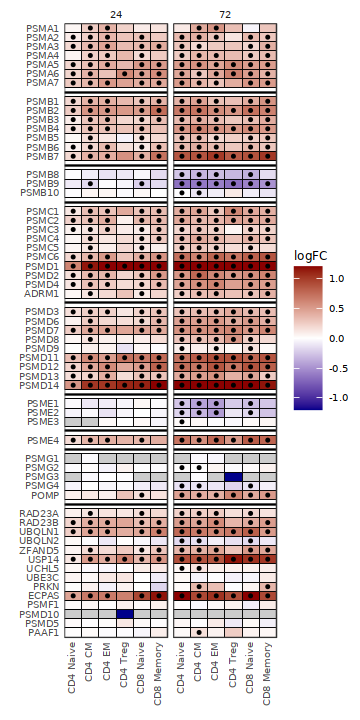

In [17]:
options(repr.plot.width = 3, repr.plot.height = 6)

psm_plot <- ggplot() +
  geom_hline(data = h_guides,
             aes(yintercept = y)) +
  geom_rect(
      data = type_plot_deg,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5,
          fill = logFC),
      color = "black",
      linewidth = 0.2
  ) +
  geom_rect(
      data = missing_pos,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5),
      fill = "gray80",
      color = "black",
      linewidth = 0.2
  ) +  
  geom_point(
      data = sig_plot_deg,
      aes(x = cell_type_xpos,
          y = gene_ypos),
      color = "black",
      shape = 16,
      size = 0.8
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      limits = c(-max_val, max_val)
  ) +
  scale_y_continuous(
      "",
      breaks = psm_genes$gene_ypos,
      labels = psm_genes$gene,
      expand = c(0,0)
  ) +
  scale_x_continuous(
      "",
      limits = c(0.5,6.5),
      breaks = type_pos$cell_type_xpos,
      labels = type_pos$cell_type_label,
      expand = c(0,0)
  ) +
  facet_grid(
      cols = vars(timepoint)
  ) + 
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())

psm_plot

In [18]:
ggsave(
    file.path(out_dir, paste0("bortezomib_psm_heatmap_", Sys.Date(), ".pdf")),
    psm_plot,
    width = 3, height = 6
)

## Ubiquitylation heatmap

In [19]:
ubi_genes <- read.csv("../common/gene_sets/ubi_genes.csv")

There are a ton of E3-associated genes. To keep the plot readable, we'll exclude these from consideration:

In [20]:
ubi_genes <- ubi_genes %>%
  filter(!grepl("E3a", gene_group)) %>%
  mutate(y_offset = ifelse(y_offset > 0, y_offset - 1, 0))

After filtering, there are still many genes available. We'll narrow the focus a bit further by retaining only significantly differentially expressed genes that also meet a differential expression cutoff:

In [21]:
sig_deg <- all_deg %>%
  filter(adjP < 0.01 & abs(logFC) > 0.3)

In [22]:
ubi_genes <- ubi_genes %>%
  filter(gene %in% sig_deg$gene) %>%
  mutate(order = n():1) %>%
  mutate(gene_ypos = order + y_offset)

In [23]:
nrow(ubi_genes)

[1] 76

In [24]:
plot_deg <- deg %>%
  filter(gene %in% ubi_genes$gene) %>%
  left_join(ubi_genes, by = c("gene" = "gene"))

In [25]:
max_val <- 1.2

type_pos <- type_colors %>%
  filter(aifi_cell_type %in% plot_deg$aifi_cell_type) %>%
  arrange(cell_type_xpos) %>%
  mutate(cell_type_xpos = 1:n())

type_plot_deg <- plot_deg %>%
  mutate(treat_label = "Bor/DMSO") %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_pos) %>%
  mutate(logFC = ifelse(
      abs(logFC) > max_val | is.na(logFC),
      max_val * direction_sign,
      logFC
  ))

sig_plot_deg <- type_plot_deg %>%
  filter(adjP < 0.01)

h_guides <- data.frame(
    y = setdiff(1:max(ubi_genes$gene_ypos), ubi_genes$gene_ypos)
)

Joining with `by = join_by(aifi_cell_type)`


In [26]:
write.csv(
    type_plot_deg,
    file.path(out_dir, paste0("bortezomib_ubi_data_", Sys.Date(), ".csv")),
    quote = FALSE, row.names = FALSE
)

In [27]:
head(type_plot_deg)

,aifi_cell_type,timepoint,fg,bg,n_sample,gene,coef_C,coef_D,logFC,nomP,⋯,source,notes,y_offset,order,gene_ypos,treat_label,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,t_cd4_cm,24,bortezomib,dmso,648,AFF4,0.04565960,0.13734940,0.06829290,1.804727e-01,⋯,https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/,Symbols converted via HGNC Multi-Symbol Checker,1,67,68,Bor/DMSO,CD4 CM,#00AEEF,2,6
2,t_cd4_cm,24,bortezomib,dmso,648,ANKIB1,-0.01700781,0.07710285,0.02386879,7.013245e-01,⋯,https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/,Symbols converted via HGNC Multi-Symbol Checker,1,66,67,Bor/DMSO,CD4 CM,#00AEEF,2,6
3,t_cd4_cm,24,bortezomib,dmso,648,ARIH1,0.04194604,0.20490724,0.10875979,8.610958e-02,⋯,https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/,Symbols converted via HGNC Multi-Symbol Checker,1,65,66,Bor/DMSO,CD4 CM,#00AEEF,2,6
4,t_cd4_cm,24,bortezomib,dmso,648,BIRC6,0.17310780,0.27117489,0.21680150,8.548677e-08,⋯,https://www.genenames.org/data/genegroup/#!/group/102,,2,75,77,Bor/DMSO,CD4 CM,#00AEEF,2,6
5,t_cd4_cm,24,bortezomib,dmso,648,CNOT4,0.03915331,0.18626978,0.09752796,1.173741e-01,⋯,https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/,Symbols converted via HGNC Multi-Symbol Checker,1,64,65,Bor/DMSO,CD4 CM,#00AEEF,2,6
6,t_cd4_cm,24,bortezomib,dmso,648,COP1,0.13753696,0.31327085,0.20730156,2.878407e-06,⋯,https://esbl.nhlbi.nih.gov/Databases/KSBP2/Targets/Lists/E3-ligases/,Symbols converted via HGNC Multi-Symbol Checker,1,45,46,Bor/DMSO,CD4 CM,#00AEEF,2,6


In [28]:
all_pos <- expand.grid(
    gene_ypos = ubi_genes$gene_ypos,
    cell_type_xpos = type_pos$cell_type_xpos,
    timepoint = c(24, 72)
)
missing_pos <- all_pos %>%
  filter(!paste(gene_ypos, cell_type_xpos, timepoint) %in% 
          paste(type_plot_deg$gene_ypos, type_plot_deg$cell_type_xpos, type_plot_deg$timepoint))

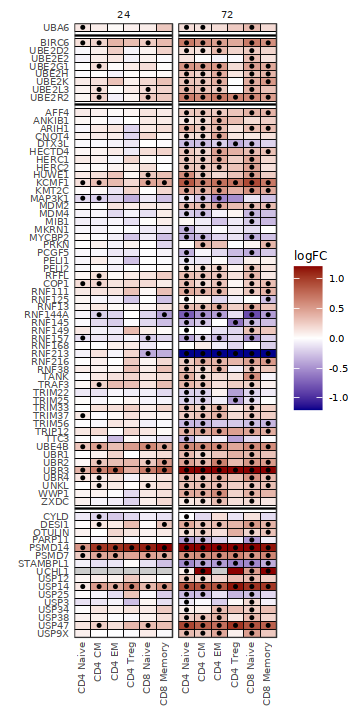

In [29]:
options(repr.plot.width = 3, repr.plot.height = 6)

ubi_plot <- ggplot() +
  geom_hline(data = h_guides,
             aes(yintercept = y)) +
  geom_rect(
      data = type_plot_deg,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5,
          fill = logFC),
      color = "black",
      linewidth = 0.2
  ) +
  geom_rect(
      data = missing_pos,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5),
      fill = "gray80",
      color = "black",
      linewidth = 0.2
  ) +  
  geom_point(
      data = sig_plot_deg,
      aes(x = cell_type_xpos,
          y = gene_ypos),
      color = "black",
      shape = 16,
      size = 0.8
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      limits = c(-max_val, max_val)
  ) +
  scale_y_continuous(
      "",
      breaks = ubi_genes$gene_ypos,
      labels = ubi_genes$gene,
      expand = c(0,0)
  ) +
  scale_x_continuous(
      "",
      limits = c(0.5,6.5),
      breaks = type_pos$cell_type_xpos,
      labels = type_pos$cell_type_label,
      expand = c(0,0)
  ) +
  facet_grid(
      cols = vars(timepoint)
  ) + 
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())

ubi_plot

In [30]:
ggsave(
    file.path(out_dir, paste0("bortezomib_ubi_heatmap_", Sys.Date(), ".pdf")),
    ubi_plot,
    width = 3, height = 6
)

## TCR heatmap

In [31]:
tcr_genes <- read.csv("../common/gene_sets/tcr_pathways.csv")

In [32]:
tcr_genes <- tcr_genes %>%
  filter(gene %in% all_deg$gene) %>%
  mutate(order = n():1) %>%
  mutate(gene_ypos = order + y_offset) %>%
  mutate(gene_label = ifelse(
      alt_name != "",
      paste(gene, "|", alt_name),
      gene
  ))

In [33]:
nrow(tcr_genes)

[1] 61

In [34]:
plot_deg <- deg %>%
  filter(gene %in% tcr_genes$gene) %>%
  left_join(tcr_genes, by = c("gene" = "gene"))

In [35]:
max_val <- 1.2

type_pos <- type_colors %>%
  filter(aifi_cell_type %in% plot_deg$aifi_cell_type) %>%
  arrange(cell_type_xpos) %>%
  mutate(cell_type_xpos = 1:n())

type_plot_deg <- plot_deg %>%
  mutate(treat_label = "Bor/DMSO") %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_pos) %>%
  mutate(logFC = ifelse(
      abs(logFC) > max_val | is.na(logFC),
      max_val * direction_sign,
      logFC
  ))

sig_plot_deg <- type_plot_deg %>%
  filter(adjP < 0.01)

h_guides <- data.frame(
    y = setdiff(1:max(tcr_genes$gene_ypos), tcr_genes$gene_ypos)
)

Joining with `by = join_by(aifi_cell_type)`


In [36]:
write.csv(
    type_plot_deg,
    file.path(out_dir, paste0("bortezomib_tcr_data_", Sys.Date(), ".csv")),
    quote = FALSE, row.names = FALSE
)

In [37]:
head(type_plot_deg)

,aifi_cell_type,timepoint,fg,bg,n_sample,gene,coef_C,coef_D,logFC,nomP,⋯,y_offset,group,order,gene_ypos,gene_label,treat_label,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,t_cd4_cm,24,bortezomib,dmso,648,BCL10,0.062854924,0.099781790,1.866188e-02,3.136672e-01,⋯,4,CBM complex,36,40,BCL10,Bor/DMSO,CD4 CM,#00AEEF,2,6
2,t_cd4_cm,24,bortezomib,dmso,648,CARD11,0.009737369,-0.012947303,-3.136485e-05,9.568378e-01,⋯,4,CBM complex,34,38,CARD11 | CARMA1,Bor/DMSO,CD4 CM,#00AEEF,2,6
3,t_cd4_cm,24,bortezomib,dmso,648,CD247,-0.009659596,-0.008508338,-1.048059e-02,9.610470e-01,⋯,5,TCR complex,56,61,CD247 | CD3ζ,Bor/DMSO,CD4 CM,#00AEEF,2,6
4,t_cd4_cm,24,bortezomib,dmso,648,CD3D,-0.022194017,-0.012657972,-1.703250e-02,7.346951e-01,⋯,5,TCR complex,60,65,CD3D | CD3δ,Bor/DMSO,CD4 CM,#00AEEF,2,6
5,t_cd4_cm,24,bortezomib,dmso,648,CD3E,-0.015860147,-0.390771582,-1.225263e-01,4.594498e-03,⋯,5,TCR complex,61,66,CD3E | CD3ε,Bor/DMSO,CD4 CM,#00AEEF,2,6
6,t_cd4_cm,24,bortezomib,dmso,648,CD3G,-0.057368448,-0.520313538,-1.974961e-01,7.473368e-06,⋯,5,TCR complex,57,62,CD3G | CD3γ,Bor/DMSO,CD4 CM,#00AEEF,2,6


In [38]:
all_pos <- expand.grid(
    gene_ypos = tcr_genes$gene_ypos,
    cell_type_xpos = type_pos$cell_type_xpos,
    timepoint = c(24, 72)
)
missing_pos <- all_pos %>%
  filter(!paste(gene_ypos, cell_type_xpos, timepoint) %in% 
          paste(type_plot_deg$gene_ypos, type_plot_deg$cell_type_xpos, type_plot_deg$timepoint))

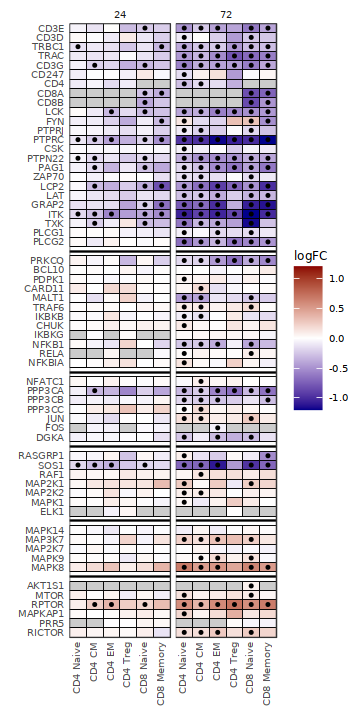

In [39]:
options(repr.plot.width = 3, repr.plot.height = 6)

tcr_plot <- ggplot() +
  geom_hline(data = h_guides,
             aes(yintercept = y)) +
  geom_rect(
      data = type_plot_deg,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5,
          fill = logFC),
      color = "black",
      linewidth = 0.2
  ) +
  geom_rect(
      data = missing_pos,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5),
      fill = "gray80",
      color = "black",
      linewidth = 0.2
  ) +  
  geom_point(
      data = sig_plot_deg,
      aes(x = cell_type_xpos,
          y = gene_ypos),
      color = "black",
      shape = 16,
      size = 0.8
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      limits = c(-max_val, max_val)
  ) +
  scale_y_continuous(
      "",
      breaks = tcr_genes$gene_ypos,
      labels = tcr_genes$gene,
      expand = c(0,0)
  ) +
  scale_x_continuous(
      "",
      limits = c(0.5,6.5),
      breaks = type_pos$cell_type_xpos,
      labels = type_pos$cell_type_label,
      expand = c(0,0)
  ) +
  facet_grid(
      cols = vars(timepoint)
  ) + 
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())

tcr_plot

In [40]:
ggsave(
    file.path(out_dir, paste0("bortezomib_tcr_heatmap_", Sys.Date(), ".pdf")),
    tcr_plot,
    width = 3, height = 6
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [45]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Fig 3", Sys.Date())

In [42]:
out_files <- list.files(
    "output/figure_3",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [44]:
out_list

[[1]]
[1] "output/figure_3/bortezomib_psm_data_2023-10-20.csv"

[[2]]
[1] "output/figure_3/bortezomib_psm_heatmap_2023-10-20.pdf"

[[3]]
[1] "output/figure_3/bortezomib_tcr_data_2023-10-20.csv"

[[4]]
[1] "output/figure_3/bortezomib_tcr_heatmap_2023-10-20.pdf"

[[5]]
[1] "output/figure_3/bortezomib_ubi_data_2023-10-20.csv"

[[6]]
[1] "output/figure_3/bortezomib_ubi_heatmap_2023-10-20.pdf"

In [46]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = deg_uuid,
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/figure_3/bortezomib_psm_data_2023-10-20.csv"

$files[[2]]
[1] "output/figure_3/bortezomib_psm_heatmap_2023-10-20.pdf"

$files[[3]]
[1] "output/figure_3/bortezomib_tcr_data_2023-10-20.csv"

$files[[4]]
[1] "output/figure_3/bortezomib_tcr_heatmap_2023-10-20.pdf"

$files[[5]]
[1] "output/figure_3/bortezomib_ubi_data_2023-10-20.csv"

$files[[6]]
[1] "output/figure_3/bortezomib_ubi_heatmap_2023-10-20.pdf"


$traceId
[1] "0d4bedad-2883-4c9a-a14e-5a5c19800ab2"

In [47]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     bitops_1.0-7      assertthat_0.2.1 
 [9] textshaping_0.3.6 systemfonts_1.0.4 